In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

# Load tudatpy modules
from tudatpy.kernel.interface import spice
from tudatpy.kernel import numerical_simulation
from tudatpy.kernel.numerical_simulation import environment_setup
from tudatpy.kernel.numerical_simulation import propagation_setup
from tudatpy.kernel.astro import element_conversion
from tudatpy.kernel import constants
from tudatpy.util import result2array

In [2]:
# Load spice kernels
spice.load_standard_kernels()

## Select Modes

In [3]:
#Case list:
#0 = no propulsion
#1 = Simple propulsion
Case_id = 1


#location list:
#1 = Mount everest top
#2 = Delft
Location_id = 1

#Laser list:
#0 = No propulsion
#1 = CO2 laser
#2 = COIL of the YAL-1
#99 =  brute force output test
Laser_type_id = 2
if Case_id ==0:
    Laser_type_id = 0

#Propellant list:
#0 = Test surface
#1 = PMMA
#2 = Pyroxylin
#3 = Aluminium
Propellant_id = 1

In [4]:
#Input settings:
#time
simulation_start_epoch = 0.0
simulation_end_epoch = 300*constants.JULIAN_DAY 
T_step = 100 #seconds

#Satellite
Satellite_mass = 3
Drag_area = 0.05
Cd_sat = 1.2
Radiation_area = 0.05
Cd_radiation = 1.2

#orbit
Altitude = 500000
ecc = 0
incl = np.deg2rad(85.3)
arg_of_peri=np.deg2rad(235.7)
long_of_asc_node=np.deg2rad(23.4)
true_anom=np.deg2rad(139.87)

Surface_area = 100

#laser
Extinction = 0.05 #0.00000001 #km-1
Tube_diameter = 1.8 #cm
Tube_length = 100 #cm
Brute_force_power = 0.00007#1e-15

#Thrust
Thrustm = 0.000007
T_i = 100000

## Constants

In [5]:
r_earth = 6371008.366666666
k = 1.380649*10**(-23) #bolzmann
UtoKg = 1.660538782*10**(-27)
g_0 = 9.80665

## Propulsion function

In [6]:
class thrust_model:
    
    def __init__(self, Laser_type_id, Surface_area, propagated_body,Location_id,Propellant_id):
        self.laserstation = laser(Laser_type_id)
        self.locationstation = location(Location_id)
        self.propellant = Propellant(Propellant_id)
        self.Sat= Sat(propagated_body)
        #self.locationstation.xyz_detemination_groundstation()
        self.Location_id = Location_id     
        self.Surface_area = Surface_area
        self.Isp = self.propellant.get_Isp()                           # Specific impulse [s]
        self.propagated_body = propagated_body   # Body that is being propagated (tudatpy.numerical_simulation.environment.Body)
        self.Propellant_id = Propellant_id
        
    def get_thrust_magnitude(self, time):
        try:
            Sat_location = self.Sat.position(time)
        except:
            Sat_location = [0,0,0]
        Range = self.locationstation.Range_calculator(Sat_location)
        Arrival_power = self.laserstation.arrival_power(Range,Extinction)
        Laser_location = location(self.Location_id)
        Max_range = Laser_location.Range_max()
        if Range <= Max_range:
            Thrustfactor = 1
        else:
            Thrustfactor = 0
        Power_recieved = Thrustfactor*Arrival_power*self.Surface_area
        if self.Propellant_id == 0:
            Flux2thrust = 0.00001
        elif self.Propellant_id == 1:
            Flux2thrust = 0.00001
        elif self.Propellant_id == 2:
            Flux2thrust = 0.00001
        elif self.Propellant_id == 3:
            Flux2thrust = 0.00001
        Thrust = Power_recieved*Flux2thrust
        return Thrust
    def get_Isp(self,time):
        Isp = self.Isp
        return Isp

## Rotation Model

## Create laser and location classes

In [7]:
##Position of laser system
class Sat:
    def __init__(self,propagated_body):
        self.propagated_body = propagated_body
    def position(self,time):
        position = [self.propagated_body.state[0],self.propagated_body.state[1],self.propagated_body.state[2]]
        return position
    
    
    
    
class location:
    def __init__(self, Location_id):
        self.Location_id = Location_id
        if self.Location_id == 1:
            self.Laser_system_altitude = 8849
            self.Laser_system_latitude = np.deg2rad(27.9881)
            self.Laser_system_longitude = np.deg2rad(86.9250)
        elif self.Location_id == 2:
            self.Laser_system_altitude = 0
            self.Laser_system_latitude = np.deg2rad(52.00667)
            self.Laser_system_longitude = np.deg2rad(4.35556)
    def xyz_detemination_groundstation(self):
        x_laser = (r_earth+self.Laser_system_altitude)* np.sin(self.Laser_system_latitude)* np.cos(self.Laser_system_longitude)
        y_laser = (r_earth+self.Laser_system_altitude)* np.sin(self.Laser_system_latitude)* np.sin(self.Laser_system_longitude)
        z_laser = (r_earth+self.Laser_system_altitude)* np.cos(self.Laser_system_latitude)
        self.Location = [x_laser,y_laser,z_laser]
        return self.Location
    def Range_calculator(self,Sat_location):
        gs_location = self.xyz_detemination_groundstation()
        difference_x = gs_location[0]-Sat_location[0]
        difference_y = gs_location[1]-Sat_location[1]
        difference_z = gs_location[2]-Sat_location[2]
        xyz = [difference_x,difference_y,difference_z]
        Range = np.linalg.norm(xyz)
        return Range
    def Range_max(self):
        Max_range = (np.sqrt((r_earth+Altitude)**2-(r_earth+self.Laser_system_altitude)**2))
        return Max_range
    
##Laser power
class laser:
    def __init__(self,Laser_type_id):
        self.Laser_type_id = Laser_type_id
        
    def output_power(self):
        if self.Laser_type_id == 0:
            output_power = 0
        elif self.Laser_type_id == 1:
            Laser_output_power_per_cm2 = 1.2E-5 #W/cm2 https://www.laserfocusworld.com/lasers-sources/article/16547243/carbon-dioxide-lasers-deliver-flexibility-and-power
            Tube_area = Tube_diameter*Tube_length 
            output_power = Laser_output_power_per_cm2*Tube_area
        elif self.Laser_type_id ==2:
            output_power = 200.
    
        elif self.Laser_type_id == 99:
            output_power = Brute_force_power
        Laser_output_power = output_power
        return Laser_output_power
    def arrival_power(self,Range,extinction):
        arrival_power = self.output_power()*(1.-extinction)**(100)
        
        return arrival_power 
class Propellant:
    def __init__(self, Propellant_id):
        self.Propellant_id = Propellant_id
        if Propellant_id == 0:
            self.ion_mass = 1
        elif Propellant_id == 1:
            self.ion_mass = 350
        elif Propellant_id == 2:
            self.ion_mass = 504.3
        elif Propellant_id == 3:
            self.ion_mass = 26.981539
    def get_Isp(self):
        if self.Propellant_id == 0:
            Isp = 350
        else:
            M_i = self.ion_mass*UtoKg
            Isp = np.sqrt(2*k*T_i/M_i)/g_0
            return Isp
        
    

## Create ablative surface settings

## Create environment, vehicle, accelerations, and propagation settings

In [8]:
###########################################################################
# CREATE ENVIRONMENT ######################################################
###########################################################################
# Define string names for bodies to be created from default.
bodies_to_create = ["Sun", "Earth", "Moon", "Mars", "Venus"]

# Use "Earth"/"J2000" as global frame origin and orientation.
global_frame_origin = "Earth"
global_frame_orientation = "J2000"

# Create default body settings, usually from `spice`.
body_settings = environment_setup.get_default_body_settings(
    bodies_to_create,
    global_frame_origin,
    global_frame_orientation)

# Create system of selected celestial bodies
bodies = environment_setup.create_system_of_bodies(body_settings)

bodies.create_empty_body( "Sat" )

bodies.get("Sat").mass = Satellite_mass

# Define the thrust magnitude as constant
# thrust_magnitude_settings = (
#     propagation_setup.thrust.custom_thrust_magnitude(thrust_magnitude_function, specific_impulse))

#Aerodynamics
reference_area = Drag_area
drag_coefficient = Cd_sat
aero_coefficient_settings = environment_setup.aerodynamic_coefficients.constant(
    reference_area, [drag_coefficient, 0, 0]
)
environment_setup.add_aerodynamic_coefficient_interface(
    bodies, "Sat", aero_coefficient_settings)


#radiation pressure
reference_area_radiation = Radiation_area
radiation_pressure_coefficient = Cd_radiation
occulting_bodies = ["Earth"]
radiation_pressure_settings = environment_setup.radiation_pressure.cannonball(
    "Sun", reference_area_radiation, radiation_pressure_coefficient, occulting_bodies
)
environment_setup.add_radiation_pressure_interface(
    bodies, "Sat", radiation_pressure_settings)



bodies_to_propagate = ["Sat"]

central_bodies = ["Earth"]

#Propulsion element
rotation_model_settings = environment_setup.rotation_model.orbital_state_direction_based(
    'Earth',
    True,
    False,
    "J2000",
    "VehicleFixed")
environment_setup.add_rotation_model( bodies, 'Sat', rotation_model_settings )

thrust_model = thrust_model(Laser_type_id, Surface_area, bodies.get('Sat'),Location_id,Propellant_id)
thrust_magnitude_settings = propagation_setup.thrust.custom_thrust_magnitude(
    thrust_model.get_thrust_magnitude,
    thrust_model.get_Isp)#,True)

environment_setup.add_engine_model(
    'Sat', 'MainEngine', thrust_magnitude_settings, bodies)

accelerations_settings_delfi_c3 = dict(
    Sat=[
        propagation_setup.acceleration.thrust_from_engine('MainEngine')
    ],
    Sun=
    [
        propagation_setup.acceleration.cannonball_radiation_pressure(),
        propagation_setup.acceleration.point_mass_gravity()
    ],
    Earth=
    [
        propagation_setup.acceleration.spherical_harmonic_gravity(5, 5),
        propagation_setup.acceleration.aerodynamic()
    ],
    Moon=
    [
        propagation_setup.acceleration.point_mass_gravity()
    ],
    Mars=
    [
        propagation_setup.acceleration.point_mass_gravity()
    ],
    Venus=
    [
        propagation_setup.acceleration.point_mass_gravity()
    ]
)

acceleration_settings = {"Sat": accelerations_settings_delfi_c3}

acceleration_models = propagation_setup.create_acceleration_models(
    bodies,
    acceleration_settings,
    bodies_to_propagate,
    central_bodies
)

earth_gravitational_parameter = bodies.get("Earth").gravitational_parameter
initial_state = element_conversion.keplerian_to_cartesian_elementwise(
    gravitational_parameter=earth_gravitational_parameter,
    semi_major_axis= bodies.get("Earth").shape_model.average_radius + Altitude,
    eccentricity=ecc,
    inclination=incl,
    argument_of_periapsis=arg_of_peri,
    longitude_of_ascending_node=long_of_asc_node,
    true_anomaly=true_anom,
)

# Define list of dependent variables to save
dependent_variables_to_save = [
    propagation_setup.dependent_variable.total_acceleration("Sat"),
    propagation_setup.dependent_variable.keplerian_state("Sat", "Earth"),
    propagation_setup.dependent_variable.latitude("Sat", "Earth"),
    propagation_setup.dependent_variable.longitude("Sat", "Earth"),
    propagation_setup.dependent_variable.single_acceleration_norm(
        propagation_setup.acceleration.point_mass_gravity_type, "Sat", "Sun"
    ),
    propagation_setup.dependent_variable.single_acceleration_norm(
        propagation_setup.acceleration.point_mass_gravity_type, "Sat", "Moon"
    ),
    propagation_setup.dependent_variable.single_acceleration_norm(
        propagation_setup.acceleration.point_mass_gravity_type, "Sat", "Mars"
    ),
    propagation_setup.dependent_variable.single_acceleration_norm(
        propagation_setup.acceleration.point_mass_gravity_type, "Sat", "Venus"
    ),
    propagation_setup.dependent_variable.single_acceleration_norm(
        propagation_setup.acceleration.spherical_harmonic_gravity_type, "Sat", "Earth"
    ),
    propagation_setup.dependent_variable.single_acceleration_norm(
        propagation_setup.acceleration.aerodynamic_type, "Sat", "Earth"
    ),
    propagation_setup.dependent_variable.single_acceleration_norm(
        propagation_setup.acceleration.cannonball_radiation_pressure_type, "Sat", "Sun"
    ),
    propagation_setup.dependent_variable.central_body_fixed_cartesian_position('Sat', 'Earth'
    ),
    propagation_setup.dependent_variable.single_acceleration_norm(
        propagation_setup.acceleration.thrust_from_engine_type, "Sat", "Sat"
    ),
    
]

In [9]:
r_earth = bodies.get("Earth").shape_model.average_radius

## Propagate Orbit

In [10]:
# Create termination settings
termination_condition = propagation_setup.propagator.time_termination(simulation_end_epoch)

# Create propagation settings
propagator_settings = propagation_setup.propagator.translational(
    central_bodies,
    acceleration_models,
    bodies_to_propagate,
    initial_state,
    termination_condition,
    output_variables=dependent_variables_to_save
)

# Create numerical integrator settings
fixed_step_size = T_step
integrator_settings = propagation_setup.integrator.runge_kutta_4(
    simulation_start_epoch, fixed_step_size
)




# Create simulation object and propagate the dynamics
dynamics_simulator = numerical_simulation.SingleArcSimulator(
    bodies, integrator_settings, propagator_settings
)

# Extract the resulting state and depedent variable history and convert it to an ndarray
states = dynamics_simulator.state_history
states_array = result2array(states)
dep_vars = dynamics_simulator.dependent_variable_history
dep_vars_array = result2array(dep_vars)

#Dependent variables being saved, output vectors contain: 
#Vector entry, Vector contents
#0, Total acceleration in inertial frame of Sat
#3, Kepler elements of Sat w.r.t. Earth
#9, Spherical position angle latitude angle of Sat w.r.t. Earth
#10, Spherical position angle longitude angle of Sat w.r.t. Earth
#11, Single acceleration norm of type central gravity , acting on Sat, exerted by Sun
#12, Single acceleration norm of type central gravity , acting on Sat, exerted by Moon
#13, Single acceleration norm of type central gravity , acting on Sat, exerted by Mars
#14, Single acceleration norm of type central gravity , acting on Sat, exerted by Venus
#15, Single acceleration norm of type spherical harmonic gravity , acting on Sat, exerted by Earth
#16, Single acceleration norm of type aerodynamic , acting on Sat, exerted by Earth
#17, Single acceleration norm of type cannonball radiation pressure , acting on Sat, exerted by Sun
#18, Cartesian coordinates of Sat wrt Earth center

## Laser calculations

In [11]:
#determine flux and sight
Cartesian_elements = dep_vars_array[:,19:22] 


## Print final propagation time and state

In [12]:
###########################################################################
# PRINT FINAL PROPAGATION TIME AND STATE ##################################
###########################################################################



## Save Results

## Plot Results

For inspiration see: 

https://tudat-space.readthedocs.io/en/latest/_src_first_steps/simulations/example_application_2.html#visualize-results

## Save and load results


In [13]:
kepler_elements = dep_vars_array[:,4:10]
time_hours = dep_vars_array[:,0]/3600
time_days = time_hours/24
Results = kepler_elements[:,0] / 1e3
np.savetxt('Case'+str(Case_id)+'results.txt',Results,delimiter=',')
np.savetxt('Case'+str(Case_id)+'time.txt',time_days,delimiter=',')

if Case_id == 0:
    Case_0 = Results
    Time_0 = time_days
    Case_1 = np.loadtxt("./Case1results.txt", delimiter = ",")
    Time_1 = np.loadtxt("./Case1time.txt", delimiter = ",")
if Case_id == 1:
    Case_0 = np.loadtxt("./Case0results.txt", delimiter = ",")
    Time_0 = np.loadtxt("./Case0time.txt", delimiter = ",")
    Case_1 = Results
    Time_1 = time_days


Text(0.5, 0, 'Time [days]')

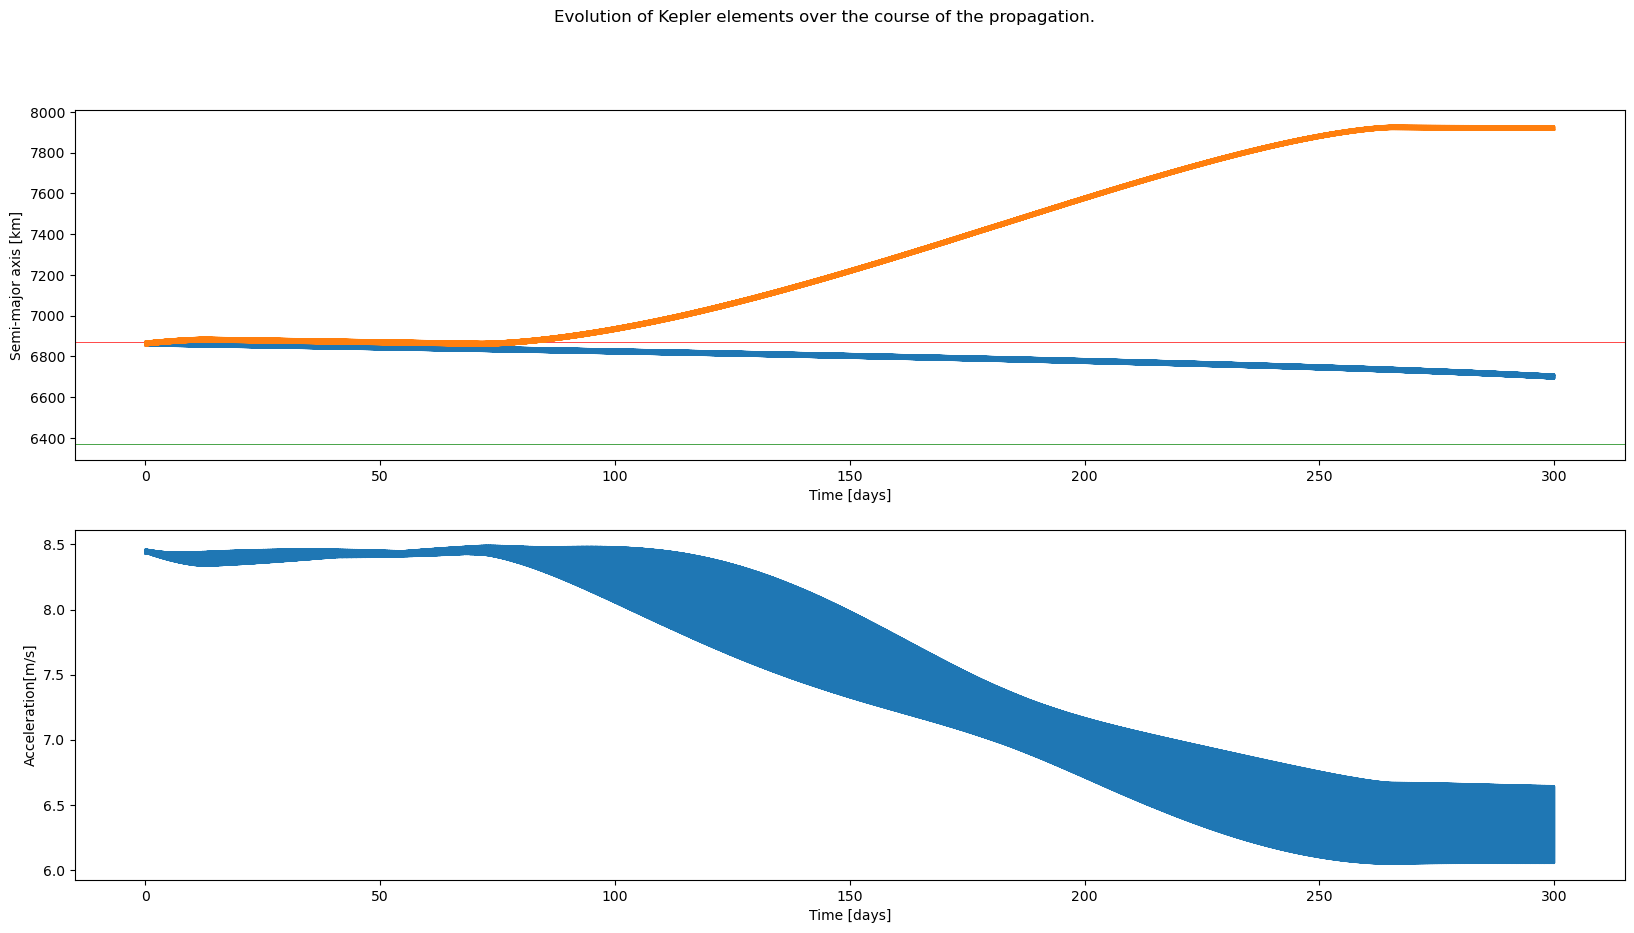

In [14]:

fig, ((ax1),(ax2)) = plt.subplots(2, 1, figsize=(20, 10))
fig.suptitle('Evolution of Kepler elements over the course of the propagation.')

# Semi-major Axis
semi_major_axis = kepler_elements[:,0] / 1e3
ax1.plot(Time_0, Case_0)
ax1.plot(Time_1, Case_1)
ax1.axhline(y= (r_earth+Altitude)/1000, xmin=0,xmax=1,c="red",linewidth=0.5,zorder=0)
ax1.axhline(y= (r_earth)/1000, xmin=0,xmax=1,c="green",linewidth=0.5,zorder=0)
#ax1.set_ylim([r_earth/1000-100, (r_earth+2*Altitude)/1000])
ax1.set_ylabel('Semi-major axis [km]')
ax1.set_xlabel('Time [days]')

accelerations = np.sqrt(dep_vars_array[:,3]**2+dep_vars_array[:,1]**2+dep_vars_array[:,2]**2)

ax2.plot(Time_1, accelerations)
ax2.set_ylabel('Acceleration[m/s]')
ax2.set_xlabel('Time [days]')

In [15]:
# # Plot Kepler elements as a function of time
# kepler_elements = dep_vars_array[:,4:10]
# fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6),(ax7, ax8),(ax9, ax10),(ax11, ax12)) = plt.subplots(6, 2, figsize=(20, 17))
# fig.suptitle('Evolution of Kepler elements over the course of the propagation.')

# # Semi-major Axis
# semi_major_axis = kepler_elements[:,0] / 1e3
# ax1.plot(time_days, semi_major_axis)
# ax1.axhline(y= (r_earth+Altitude)/1000, xmin=0,xmax=1,c="red",linewidth=0.5,zorder=0)
# ax1.set_ylim([r_earth/1000, (r_earth+2*Altitude)/1000])
# ax1.set_ylabel('Semi-major axis [km]')

# # Eccentricity
# eccentricity = kepler_elements[:,1]
# ax2.plot(time_days, eccentricity)
# ax2.set_ylabel('Eccentricity [-]')

# # Inclination
# inclination = np.rad2deg(kepler_elements[:,2])
# ax3.plot(time_days, inclination)
# ax3.set_ylabel('Inclination [deg]')

# # Argument of Periapsis
# argument_of_periapsis = np.rad2deg(kepler_elements[:,3])
# ax4.plot(time_days, argument_of_periapsis)
# ax4.set_ylabel('Argument of Periapsis [deg]')

# # Right Ascension of the Ascending Node
# raan = np.rad2deg(kepler_elements[:,4])
# ax5.plot(time_days, raan)
# ax5.set_ylabel('RAAN [deg]')

# # True Anomaly
# true_anomaly = np.rad2deg(kepler_elements[:,5])
# ax6.scatter(time_days, true_anomaly, s=1)
# ax6.set_ylabel('True Anomaly [deg]')
# ax6.set_yticks(np.arange(0, 361, step=60))

# # X,Y,Z, of sat
# Xcoorofsat = (Cartesian_elements[:,0])
# Ycoorofsat = (Cartesian_elements[:,1])
# Zcoorofsat = (Cartesian_elements[:,2])
# #ax7.plot(time_days, Xcoorofsat)
# #ax7.plot(time_days, Ycoorofsat)
# #ax7.plot(time_days, Zcoorofsat)
# ax7.plot(time_days, np.sqrt(Zcoorofsat**2 + Ycoorofsat**2 + Xcoorofsat**2)/1000)
# ax7.set_ylabel('XYZ')

# ax8.plot(time_days, Range/1000)
# ax8.axhline(y= Range_max/1000, xmin=0,xmax=1,c="red",linewidth=0.5,zorder=0)
# ax8.set_ylabel('Range with laser')

# ax9.plot(time_days, On_Off_lst)

# ax9.set_ylabel('On or Off')



# for ax in fig.get_axes():
#     ax.set_xlabel('Time [day]')
#     ax.set_xlim([min(time_days), max(time_days)])
#     ax.grid()
# plt.tight_layout()

In [16]:
# plt.figure(figsize=(17, 5))

# # Point Mass Gravity Acceleration Sun
# acceleration_norm_pm_sun = dep_vars_array[:,12]
# plt.plot(time_days, acceleration_norm_pm_sun, label='PM Sun')

# # Point Mass Gravity Acceleration Moon
# acceleration_norm_pm_moon = dep_vars_array[:,13]
# plt.plot(time_days, acceleration_norm_pm_moon, label='PM Moon')

# # Point Mass Gravity Acceleration Mars
# acceleration_norm_pm_mars = dep_vars_array[:,14]
# plt.plot(time_days, acceleration_norm_pm_mars, label='PM Mars')

# # Point Mass Gravity Acceleration Venus
# acceleration_norm_pm_venus = dep_vars_array[:,15]
# plt.plot(time_days, acceleration_norm_pm_venus, label='PM Venus')

# # Spherical Harmonic Gravity Acceleration Earth
# acceleration_norm_sh_earth = dep_vars_array[:,16]
# plt.plot(time_days, acceleration_norm_sh_earth, label='SH Earth')

# # Aerodynamic Acceleration Earth
# acceleration_norm_aero_earth = dep_vars_array[:,17]
# plt.plot(time_days, acceleration_norm_aero_earth, label='Aerodynamic Earth')

# # Cannonball Radiation Pressure Acceleration Sun
# acceleration_norm_rp_sun = dep_vars_array[:,18]
# plt.plot(time_days, acceleration_norm_rp_sun, label='Radiation Pressure Sun')


# plt.title("Accelerations norms on Sat, distinguished by type and origin, over the course of propagation.")
# plt.xlim([min(time_days), max(time_days)])
# plt.xlabel('Time [hr]')
# plt.ylabel('Acceleration Norm [m/s$^2$]')

# plt.legend(bbox_to_anchor=(1.005, 1))
# plt.yscale('log')
# plt.grid()
# plt.tight_layout()